In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import attila_utils

In [2]:
treatments_CO28152 = {
    'A': 'Amiloride TG',
    'B': 'HCQ TG',
    'C': 'HCQ nano TG',
    'D': 'Saline TG',
    'E': 'R-HCQ TG',
    'F': 'S-HCQ TG',
    'G': 'TUDCA TG',
    'H': 'Saline WT',
    'I': 'TUDCA WT',
    'J': 'DMSO WT',
}

treatments_CO28154 = {
    'A': 'Saline TG',
    #'B': 'Amiloride + HCQ TG', # absent from data
    'C': 'TUDCA + HCQ TG',
    'D': 'Arundine low dose TG',
    'E': 'Arundine mid dose TG',
    'F': 'Arundine high dose TG',
    'G': 'Vehicle (Arundine) TG',
    'H': 'Arundine high dose WT',
    #'I': 'Amiloride + HCQ WT', # absent from data
    'J': 'TUDCA + HCQ WT',
    'K': 'Saline WT',
    'L': 'Vehicle (Arundine) WT',
}

fpathl = ['../../resources/QPS/5xFAD-mouse/CO2815' + i + '-biochemistry-cleaned-Abeta.xlsx' for i in ['2', '4']]

def import_helper(fpath, study, treatments, index_cols=['Cohort', 'Group', 'IRN', 'Sex', 'Genotype']):
    df = pd.read_excel(fpath, sheet_name='Abeta', header=[0, 1], index_col=[0, 1, 2, 3, 4])
    ix = df.index.to_frame()#index_cols
    ix = ix.rename(dict(zip(np.arange(len(index_cols)), index_cols)), axis=1)
    ix['Study'] = study
    ix['Treatment'] = ix.Group.apply(lambda x: treatments[x])
    df = pd.DataFrame(df.to_numpy(), index=pd.MultiIndex.from_frame(ix), columns=df.columns)
    return(df)

Z = zip(fpathl, ['CO28152', 'CO28154'], [treatments_CO28152, treatments_CO28154])
Abeta = pd.concat([import_helper(f, s, t) for f, s, t in Z], axis=0)
Abeta

CX FA  \
Genotype                                                                 Aβ40   
Cohort Group IRN     Sex Genotype Study   Treatment                             
I      A     15117   f   tg/wt    CO28152 Amiloride TG           17651.361718   
             15119   f   tg/wt    CO28152 Amiloride TG           15331.812020   
             14627 A f   tg/wt    CO28152 Amiloride TG           16698.646055   
III    A     15161   f   tg/wt    CO28152 Amiloride TG           10839.483178   
II     A     15938   m   tg/wt    CO28152 Amiloride TG            4339.596561   
...                                                                       ...   
IV     L     15823   f   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
VII    L     16145   f   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
III    L     16746   m   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
IV     L     16802   m   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
VI     L     17020   m   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   

                                                                                \
Genotype                                                                  Aβ42   
Cohort Group IRN     Sex Genotype Study   Treatment                              
I      A     15117   f   tg/wt    CO28152 Amiloride TG           116029.444713   
             15119   f   tg/wt    CO28152 Amiloride TG            93464.357730   
             14627 A f   tg/wt    CO28152 Amiloride TG           109435.604680   
III    A     15161   f   tg/wt    CO28152 Amiloride TG            65693.648426   
II     A     15938   m   tg/wt    CO28152 Amiloride TG            56334.531795   
...                                                                        ...   
IV     L     15823   f   wt/wt    CO28154 Vehicle (Arundine) WT            NaN   
VII    L     16145   f   wt/wt    CO28154 Vehicle (Arundine) WT      26.665591   
III    L     16746   m   wt/wt    CO28154 Vehicle (Arundine) WT            NaN   
IV     L     16802   m   wt/wt    CO28154 Vehicle (Arundine) WT            NaN   
VI     L     17020   m   wt/wt    CO28154 Vehicle (Arundine) WT            NaN   

                                                                        HC FA  \
Genotype                                                                 Aβ40   
Cohort Group IRN     Sex Genotype Study   Treatment                             
I      A     15117   f   tg/wt    CO28152 Amiloride TG           18612.586998   
             15119   f   tg/wt    CO28152 Amiloride TG           17893.589944   
             14627 A f   tg/wt    CO28152 Amiloride TG           21920.822859   
III    A     15161   f   tg/wt    CO28152 Amiloride TG           15996.584917   
II     A     15938   m   tg/wt    CO28152 Amiloride TG            6756.283660   
...                                                                       ...   
IV     L     15823   f   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
VII    L     16145   f   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
III    L     16746   m   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
IV     L     16802   m   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   
VI     L     17020   m   wt/wt    CO28154 Vehicle (Arundine) WT           NaN   

                                                                                \
Genotype                                                                  Aβ42   
Cohort Group IRN     Sex Genotype Study   Treatment                              
I      A     15117   f   tg/wt    CO28152 Amiloride TG           110505.749236   
             15119   f   tg/wt    CO28152 Amiloride TG           122377.869230   
             14627 A f   tg/wt    CO28152 Amiloride TG           137676.050925   
III    A     15161   f   tg/wt    CO28152 Amiloride TG           102235.507686   
II     A     15938   m   tg/wt    CO28152 Amiloride TG            63092.054319 

In [3]:
def extract_subset(region_fraction='CX FA', Abeta=Abeta):
    df = Abeta.xs(region_fraction, level=0, axis=1)
    df0 = df.index.to_frame()
    dff = pd.concat([df0, df], axis=1)
    val = dff.melt(id_vars=df0.columns, var_name='Alloform', value_name='Abeta')
    region, fraction = region_fraction.split(' ')
    val['Region'] = {'CX': 'cortex', 'HC': 'hippocampus'}[region]
    val['Fraction'] = fraction
    return(val)

Abeta_long = pd.concat([extract_subset(rf) for rf in Abeta.columns.to_frame().iloc[:, 0].unique()], axis=0)
Abeta_long = pd.DataFrame(Abeta_long.to_numpy(), columns=Abeta_long.columns)
Abeta_long

,Cohort,Group,IRN,Sex,Genotype,Study,Treatment,Alloform,Abeta,Region,Fraction
0,I,A,15117,f,tg/wt,CO28152,Amiloride TG,Aβ40,17651.361718,cortex,FA
1,I,A,15119,f,tg/wt,CO28152,Amiloride TG,Aβ40,15331.81202,cortex,FA
2,I,A,14627 A,f,tg/wt,CO28152,Amiloride TG,Aβ40,16698.646055,cortex,FA
3,III,A,15161,f,tg/wt,CO28152,Amiloride TG,Aβ40,10839.483178,cortex,FA
4,II,A,15938,m,tg/wt,CO28152,Amiloride TG,Aβ40,4339.596561,cortex,FA
...,...,...,...,...,...,...,...,...,...,...,...
955,IV,L,15823,f,wt/wt,CO28154,Vehicle (Arundine) WT,Aβ42,NaN,hippocampus,DEA
956,VII,L,16145,f,wt/wt,CO28154,Vehicle (Arundine) WT,Aβ42,NaN,hippocampus,DEA
957,III,L,16746,m,wt/wt,CO28154,Vehicle (Arundine) WT,Aβ42,NaN,hippocampus,DEA
958,IV,L,16802,m,wt/wt,CO28154,Vehicle (Arundine) WT,Aβ42,NaN,hippocampus,DEA


['named-figure/boxplot-Abeta-TUDCA-and-HCQ.png',
 'named-figure/boxplot-Abeta-TUDCA-and-HCQ.pdf']

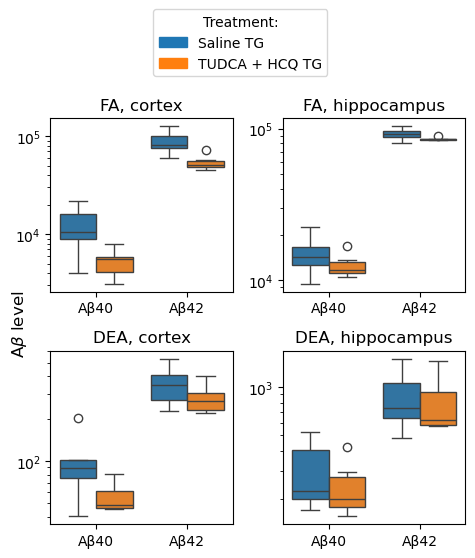

In [12]:
def my_plot_ax(ax, treatments=['Saline TG', 'TUDCA + HCQ TG'], study='CO28154', x='Alloform', hue='Treatment', subsetd={'Fraction': 'FA', 'Region': 'cortex'}, Abeta_long=Abeta_long):
    b = (Abeta_long.Treatment.isin(treatments)) & (Abeta_long.Study == study)
    b = b & (Abeta_long[list(subsetd.keys())[0]] == list(subsetd.values())[0]) & (Abeta_long[list(subsetd.keys())[1]] == list(subsetd.values())[1])
    sns.boxplot(x=x, y='Abeta', hue=hue, data=Abeta_long.loc[b], ax=ax, legend=False)
    ax.set_yscale('log')
    ax.set_title(', '.join(list(subsetd.values())))
    return(ax)

def my_plot(treatments=['Saline TG', 'TUDCA + HCQ TG'], study='CO28154'):
    fig, ax = plt.subplots(2, 2, figsize=(4.8, 4.8))
    for i, fraction in enumerate(['FA', 'DEA']):
        for j, region in enumerate(['cortex', 'hippocampus']):
            axi = ax[i, j]
            axi = my_plot_ax(axi, treatments=treatments, study=study, x='Alloform', hue='Treatment', subsetd={'Fraction': fraction, 'Region': region})
            axi.set_xlabel('')
            axi.set_ylabel('')

    handles = [mpatches.Patch(color=c) for c in ['C' + str(i) for i in list(range(len(treatments)))]]
    fig.legend(handles=handles, labels=treatments, loc='lower center', bbox_to_anchor=(0.5, 1.0), title='Treatment:')
    fig.tight_layout()
    fig.supylabel(r'A$\beta$ level')
    #fig.supxlabel(r'Alloform')
    return((fig, ax))

fig, ax = my_plot(treatments=['Saline TG', 'TUDCA + HCQ TG'], study='CO28154')
attila_utils.savefig(fig, 'boxplot-Abeta-TUDCA-and-HCQ')

['named-figure/boxplot-Abeta-TUDCA-or-HCQ.png',
 'named-figure/boxplot-Abeta-TUDCA-or-HCQ.pdf']

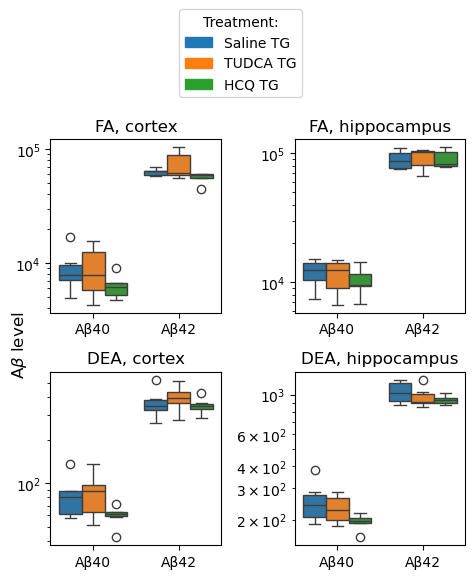

In [13]:
fig, ax = my_plot(treatments=['Saline TG', 'TUDCA TG', 'HCQ TG'], study='CO28152')
attila_utils.savefig(fig, 'boxplot-Abeta-TUDCA-or-HCQ')

In [6]:
%connect_info

{
  "shell_port": 58939,
  "iopub_port": 58940,
  "stdin_port": 58941,
  "control_port": 58943,
  "hb_port": 58942,
  "ip": "127.0.0.1",
  "key": "87678a05-9d6c7fc7b48fdf2a71cf9055",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "conda-base-py",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-08-08-biochemistry/2024-08-08-biochemistry.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-2f80ec83-b503-4519-bd7a-9c583a61782c.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
